In [30]:
from operator import indexOf
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import functools

# regatta_names = ["nwisa-girls-qualifiers", "cascadia-cup-gold", "2022-issa-pcisa-all-girls-invitational",
#                  "pontiac-bay-regional-south-regional", "fall-champs", "2022-atlantic-coast"]
# better_names = ["girls quals", "cascadia gold", "PCISA girls",
#                 "south regional", "fall champs", "ACCs"]
regatta_names = ["2022-atlantic-coast"]
better_names = ["ACCs"]


class person:
    def __init__(self, name, team, races):
        self.name = name
        self.team = team
        self.races = races
        # self.raceNums = []
            # print(self.races)

    def __repr__(self):
        return f"{self.name} {self.team} {self.races}"

class race:
    def __init__(self, number, division, score, teams, position, venue):
        self.number = number
        self.division = division
        self.score = score
        self.teams = teams
        self.position = position
        self.venue = venue

    def __repr__(self):
        return f"#: {self.number} D:{self.division} s:{self.score} t:{len(self.teams)} {self.position}"

people = []

def addPerson(name, pos, division, home, raceNums, scores, teams, venue):
    newNums = []
    if name not in [p.name for p in people]:
        people.append(person(name, home, []))
    if raceNums == [['']]:
        newNums = list(range(len(scores)))
        # print(raceNums)
    elif len(raceNums) != 0:
        for i, num in enumerate(raceNums):
            if len(num) > 1:
                for j in range(int(num[0]), int(num[1]) + 1):
                    newNums.append(j)
            else:
                newNums.append(int(num[0]))
    raceNums = newNums
    for i, score in enumerate(scores):
        if i + 1 in raceNums:
            for s in people:
                if s.name == name:
                    s.races.append(race(
                        i + 1, division, score, [t for t in teams], pos, venue))

def getData(type, name, fleet, division, position, pair, regatta):
    if type == "raw":
        return next([race.score for race in p.races]
                    for p in people if p.name == name)
    if type == "points":
        data = {}
        for p in people:
            if p.name == name:
                # racenum = 0
                for r in p.races:
                    # print(r.score)
                    if r.venue == regatta:
                        data[f"{regatta} {r.division}{r.number}"] = r.score
                    # data[f"{regatta} race {r.number}"] = len(
                    #     r.teams) - r.score + 1
                    # racenum++
        return data

        return next([(len(race.teams) - race.score + 1) for race in p.races]
                    for p in people if p.name == name)


def getVenues(name):
    return next([race.venue for race in p.races]for p in people if p.name == name)


def getDataByVenue(name, rregatta):
    return next([(len(race.teams) - race.score + 1) for race in p.races if race.venue == rregatta]
                for p in people if p.name == name)

for i, regatta in enumerate(regatta_names):
    betterVenue = better_names[i]
    print(f"({i + 1}/{len(regatta_names)})analyzing {betterVenue}")
    # full scores
    url = f"https://scores.hssailing.org/f22/{regatta}/full-scores/"
    page = requests.get(url)
    fullScores = BeautifulSoup(page.content, 'html.parser')

    # sailors a
    url = f"https://scores.hssailing.org/f22/{regatta}/sailors/"
    page = requests.get(url)
    sailors = BeautifulSoup(page.content, 'html.parser')

    # A
    url = f"https://scores.hssailing.org/f22/{regatta}/A/"
    page = requests.get(url)
    a = BeautifulSoup(page.content, 'html.parser')

    # B
    url = f"https://scores.hssailing.org/f22/{regatta}/B/"
    page = requests.get(url)
    b = BeautifulSoup(page.content, 'html.parser')

    scoreData = fullScores.find('table', class_="results").contents[1].contents
    aData = a.find('table', class_="results").contents[1].contents
    bData = b.find('table', class_="results").contents[1].contents
    sailorData = sailors.find('table', class_="sailors").contents[1].contents
    header = fullScores.find(
        'table', class_="results").find_all('th', class_="right")
    raceCount = int(header[len(header) - 2].text)

    teamCount = int(len(scoreData) / 3)

    teamHomes = [(scoreData[(i*3) - 3].find('a').text) for i in range(teamCount)]

    teams = []

    # loop through teams
    for i in range(1, teamCount):
        teamHome = scoreData[(i*3) - 3].find('a').text
        teamName = scoreData[(i*3) - 2].contents[2].text

        teamAScores = []
        for j in range(4, (4 + raceCount)):
            score = scoreData[(i*3) - 3].contents[j].text
            if score.isdigit():
                score = int(score)
            teamAScores.append(score)

        teamBScores = []
        for j in range(4, (4 + raceCount)):
            score = scoreData[(i*3) - 2].contents[j].text
            if score.isdigit():
                score = int(score)
            teamBScores.append(score)

        teamATotal = int(scoreData[(i*3) - 3].contents[5 + raceCount].text)
        teamBTotal = int(scoreData[(i*3) - 2].contents[5 + raceCount].text)

        teamASkippers = []
        teamACrews = []
        teamBSkippers = []
        teamBCrews = []

        allNames = a.find_all('td', class_="teamname")
        teamNameEl = [i for i in allNames if i.text == teamName][0]

        for skipper in teamNameEl.parent.previous_sibling.find_all('td', class_="skipper"):
            if skipper.parent.previous_sibling and skipper.parent.previous_sibling.find_all('td', class_="skipper"):
                skipper2 = skipper.parent.previous_sibling.find(
                    'td', class_="skipper")
                raceNums = skipper2.next_sibling.text.split(",")
                raceNums = [i.split("-", 1) for i in raceNums]
                addPerson(skipper2.text.split(" '")[0],"Skipper", 'A', teamHome, raceNums, teamAScores, teamHomes, betterVenue)
            raceNums = skipper.next_sibling.text.split(",")
            raceNums = [i.split("-", 1) for i in raceNums]
            addPerson(skipper.text.split(" '")[0],"Skipper",'A', teamHome, raceNums, teamAScores, teamHomes, betterVenue)
            # teamASkippers.append(
            #     person(skipper.text.split(" '")[0], "skipper", raceNums, races))

        for crew in teamNameEl.parent.find_all('td', class_="crew"):
            races = crew.next_sibling.text.split(",")
            races = [i.split("-", 1) for i in races]
            addPerson(crew.text.split(" '")[0],"Crew",'A', teamHome, races, teamAScores, teamHomes, betterVenue)
            if crew.parent.next_sibling and crew.parent.next_sibling.find_all('td', class_="crew"):
                crew2 = crew.parent.next_sibling.find(
                    'td', class_="crew")
                races = crew2.next_sibling.text.split(",")
                races = [i.split("-", 1) for i in races]
                addPerson(crew2.text.split(" '")[0],"Crew",'A', teamHome, races, teamAScores, teamHomes, betterVenue)
                if crew2.parent.next_sibling and crew2.parent.next_sibling.find_all('td', class_="crew"):
                    crew3 = crew2.parent.next_sibling.find(
                        'td', class_="crew")
                    races = crew3.next_sibling.text.split(",")
                    races = [i.split("-", 1) for i in races]
                    addPerson(crew3.text.split(" '")[0],"Crew",'A', teamHome, races, teamAScores, teamHomes, betterVenue)

        allNames = b.find_all('td', class_="teamname")
        teamNameEl = [i for i in allNames if i.text == teamName][0]

        for skipper in teamNameEl.parent.previous_sibling.find_all('td', class_="skipper"):
            if skipper.parent.previous_sibling and skipper.parent.previous_sibling.find_all('td', class_="skipper"):
                skipper2 = skipper.parent.previous_sibling.find(
                    'td', class_="skipper")
                races = skipper2.next_sibling.text.split(",")
                races = [i.split("-", 1) for i in races]
                addPerson(skipper2.text.split(" '")[0],"Skipper",'B', teamHome, races, teamAScores, teamHomes, betterVenue)
            races = skipper.next_sibling.text.split(",")
            races = [i.split("-", 1) for i in races]
            addPerson(skipper.text.split(" '")[0],"Skipper",'A', teamHome, races, teamAScores, teamHomes, betterVenue)

        for crew in teamNameEl.parent.find_all('td', class_="crew"):
            races = crew.next_sibling.text.split(",")
            races = [i.split("-", 1) for i in races]
            addPerson(crew.text.split(" '")[0],"Crew",'B', teamHome, races, teamAScores, teamHomes, betterVenue)
            if crew.parent.next_sibling and crew.parent.next_sibling.find_all('td', class_="crew"):
                crew2 = crew.parent.next_sibling.find(
                    'td', class_="crew")
                races = crew2.next_sibling.text.split(",")
                races = [i.split("-", 1) for i in races]
                addPerson(crew2.text.split(" '")[0],"Crew",'B', teamHome, races, teamAScores, teamHomes, betterVenue)

                if crew2.parent.next_sibling and crew2.parent.next_sibling.find_all('td', class_="crew"):
                    crew3 = crew2.parent.next_sibling.find(
                        'td', class_="crew")
                    races = crew3.next_sibling.text.split(",")
                    races = [i.split("-", 1) for i in races]
                    addPerson(crew3.text.split(" '")[0],"Crew",'B', teamHome, races, teamAScores, teamHomes, betterVenue)

# print(people)

(1/1)analyzing ACCs


plotting Elliott Chalcraft for girls quals prev:0
Elliott Chalcraft {'girls quals A1': 7, 'girls quals A2': 1, 'girls quals A5': 7, 'girls quals A6': 8, 'girls quals A7': 3, 'girls quals A8': 7, 'girls quals A9': 4}
plotting Carter Anderson for girls quals prev:0
Carter Anderson {}
plotting Elliott Chalcraft for cascadia gold prev:7
Elliott Chalcraft {}
plotting Carter Anderson for cascadia gold prev:7
Carter Anderson {'cascadia gold A1': 6, 'cascadia gold A2': 8}
plotting Elliott Chalcraft for PCISA girls prev:9
Elliott Chalcraft {'PCISA girls A1': 21, 'PCISA girls A2': 23, 'PCISA girls A3': 18, 'PCISA girls A4': 23, 'PCISA girls A5': 23, 'PCISA girls A6': 21}
plotting Carter Anderson for PCISA girls prev:9
Carter Anderson {}
plotting Elliott Chalcraft for south regional prev:15
Elliott Chalcraft {'south regional A1': 17, 'south regional A2': 19, 'south regional A3': 7, 'south regional A4': 12, 'south regional A5': 15, 'south regional A6': 15, 'south regional A7': 15}
plotting Carter 

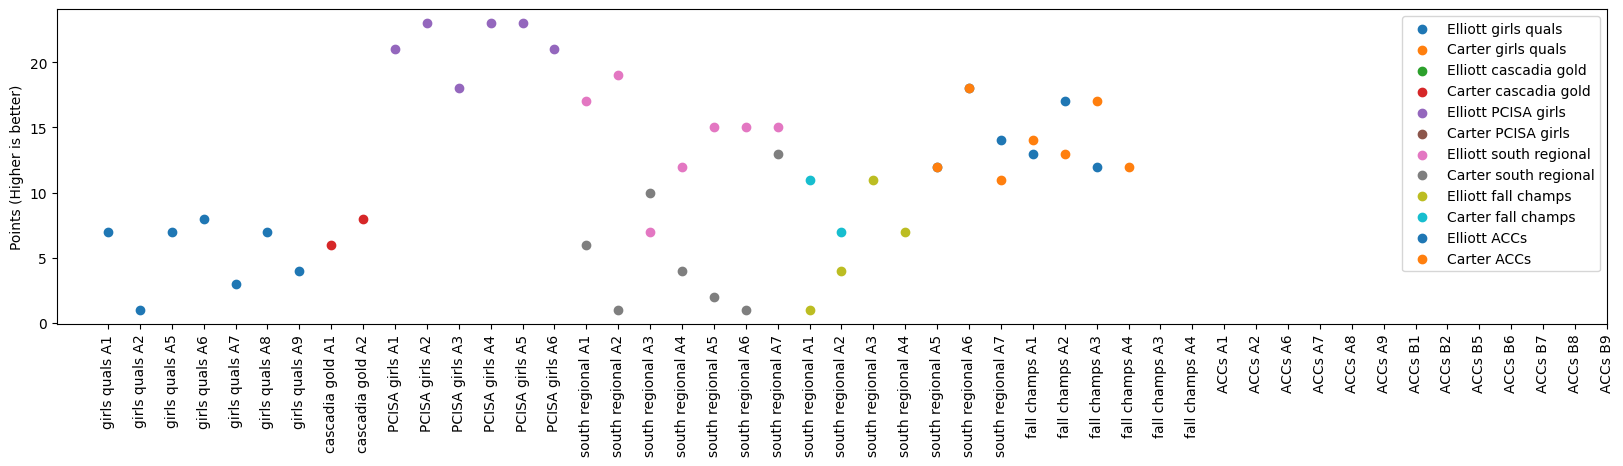

In [7]:

names = ["Elliott Chalcraft", 'Carter Anderson'] 
Type = "points"

ind = 0
data = []
venues = []

def compare(first, second):
    # print("First", first, "Second", second)
    if first[len(first) - 1] > second[len(second) - 1]:
        return 1
    #B > A
    elif first[len(first) - 2] > second[len(second) - 2]:
        return - 1
        # elif indexOf(better_names, first[0:len(first)-3]) > indexOf(better_names, first[0:len(first)-3]):
        #     return - 1
        # elif indexOf(better_names, first[0:len(first)-3]) < indexOf(better_names, first[0:len(first)-3]):
        #     return 1
    else:
        return 0

prev = 0
for regatta in better_names:
    dataLengths = []
    for i, p in enumerate(names):
        print(f"plotting {p} for {regatta} prev:{prev}")
        try:
            data.append(getData(Type, p, None, None, None, None, regatta))
            print(p, data[len(data) - 1])
        except:
            print("Couldn't find person 👀")

        pData = list(data[len(data) - 1].keys())
        # print("Pdata",pData)
        pData = sorted(pData, key=functools.cmp_to_key(compare))
        # print("Pdata",pData)
        venues.extend(pData)


    # list out x values tied with race names
    # attach same x value to next person if same name
    # graph each person with new x values


    x = range(prev, prev + len(pData))
    y = [data[len(data) - 1][i] for i in pData]
    dataLengths.append(len(pData))
    # if i == len(names) - 1:
        
    plt.scatter(x, y, label=f'{p.split(" ", 1)[0]} {regatta}')

    # x = list(range(len(data[len(data) - 1].values())))
    # y = list(data[indexOf(dataLengths, max(dataLengths))].values())
    prev += max(dataLengths)
    dataLengths = []
    # print("HAI",x,y)
    # plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xticks(range(len(venues)), venues, rotation=90)

# print(getVenues)

plt.ylabel("Points (Higher is better)")
plt.figure(figsize=(20, 5))
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.25)
plt.savefig("fig.png")

plt.show()

In [42]:
def compare(first, second):
    print("First", first, "Second", second)
    #B > A
    if first[len(first) - 1] > second[len(second) - 1]:
        print("putting ahead #")
        return 1
    if first[len(first) - 1] < second[len(second) - 1]:
        print("putting behind #")
        return - 1
    if first[len(first) - 2] > second[len(second) - 2]:
        print("putting ahead L")
        return 1
    if first[len(first) - 2] < second[len(second) - 2]:
        print("putting behind L")
        return - 1
    else:
        return 0

names = ["Elliott Chalcraft", 'Carter Anderson'] 
Type = "points"

prev = 0
for regatta in better_names:
    data = {}
    # regatta_x_vals = {}
    xVals = {}
    for p in names:
        try:
            data[p] = getData(Type, p, None, None, None, None, regatta)
        # print(p, data[len(data) - 1])
        except:
            print("Couldn't find person 👀")
        # print(p, "Datum:",data[p])
        prevX = prev
        for race in data[p].keys():
            if xVals.get(race) == None:
                xVals[race] = prevX
                prevX += 1
        prev = prevX
        # print(xVals)
    print(f"{regatta} {xVals}")
    xValKeys = sorted(list(xVals.keys()), key=functools.cmp_to_key(compare))
    print(f"{regatta} {xValKeys}")

    # list out x values tied with race names
    # attach same x value to next person if same name
    # graph each person with new x values

    for p in names:
        print(xVals)
        x = [xVals[xValKeys] for bruh in xValKeys if data[p].get(bruh) != None]
        print(x)


ACCs {'ACCs A1': 0, 'ACCs A2': 1, 'ACCs A6': 2, 'ACCs A7': 3, 'ACCs A8': 4, 'ACCs A9': 5, 'ACCs B1': 6, 'ACCs B2': 7, 'ACCs B5': 8, 'ACCs B6': 9, 'ACCs B7': 10, 'ACCs B8': 11, 'ACCs B9': 12}
First ACCs A2 Second ACCs A1
putting ahead #
First ACCs A6 Second ACCs A2
putting ahead #
First ACCs A7 Second ACCs A6
putting ahead #
First ACCs A8 Second ACCs A7
putting ahead #
First ACCs A9 Second ACCs A8
putting ahead #
First ACCs B1 Second ACCs A9
putting behind #
First ACCs B1 Second ACCs A7
putting behind #
First ACCs B1 Second ACCs A2
putting behind #
First ACCs B1 Second ACCs A1
putting ahead L
First ACCs B2 Second ACCs A6
putting behind #
First ACCs B2 Second ACCs B1
putting ahead #
First ACCs B2 Second ACCs A2
putting ahead L
First ACCs B5 Second ACCs A6
putting behind #
First ACCs B5 Second ACCs A2
putting ahead #
First ACCs B5 Second ACCs B2
putting ahead #
First ACCs B6 Second ACCs B5
putting ahead #
First ACCs B6 Second ACCs A8
putting behind #
First ACCs B6 Second ACCs A7
putting b

TypeError: unhashable type: 'list'